# Model Evaluation & Optimization - Ryanair Customer Query Classification
## **Objective**: Deep evaluation and optimization of the best performing models.
## **Evaluation Strategy:**
### 1. **Cross-validation**: Stratified K-fold for robust performance estimation
### 2. **Confusion Matrix Analysis**: Detailed error pattern analysis
### 3. **Per-class Performance**: Category-wise metrics deep dive
### 4. **Error Analysis**: Understanding model failures
### 5. **Hyperparameter Tuning**: Optimize best models
### 6. **Learning Curves**: Overfitting and bias analysis
### 7. **Feature Importance**: Understanding model decisions

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import warnings
from datetime import datetime
import itertools
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import (
    cross_val_score, StratifiedKFold, validation_curve, 
    learning_curve, RandomizedSearchCV, GridSearchCV
)
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
import joblib

# Gradient boosting (if available)
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False

try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
except ImportError:
    LGB_AVAILABLE = False

try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False

print("All libraries imported successfully!")

All libraries imported successfully!


In [4]:
# Load processed data and best models
print("Loading Data and Best Models...")
# Load data
train_split = pd.read_csv('../data/processed/train_split.csv')
val_split = pd.read_csv('../data/processed/val_split.csv')

# Combine train and validation for cross-validation
full_data = pd.concat([train_split, val_split], ignore_index=True)
X_full = full_data['query_original'].fillna("")
y_full = full_data['label_encoded']

# Load label encoder
with open('../data/processed/label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Load model artifacts
with open('../models/model_artifacts.json', 'r') as f:
    model_artifacts = json.load(f)

print(f"Data loaded successfully!")
print(f"Full dataset: {len(X_full):,} samples")
print(f"Classes: {len(label_encoder.classes_)}")
print(f"Best model from previous run: {model_artifacts['best_model']}")

Loading Data and Best Models...
Data loaded successfully!
Full dataset: 20,000 samples
Classes: 30
Best model from previous run: Advanced_SVM


## 1. Cross-Validation Analysis


1. CROSS-VALIDATION ANALYSIS

📊 Cross-validating Logistic_Regression...
   F1-Score: 0.9858 ± 0.0013
   Range: [0.9840, 0.9877]

📊 Cross-validating SVM...
   F1-Score: 0.9872 ± 0.0020
   Range: [0.9842, 0.9900]

📊 Cross-validating Random_Forest...
   F1-Score: 0.9842 ± 0.0011
   Range: [0.9827, 0.9855]

📊 Cross-validating XGBoost...
   F1-Score: 0.9801 ± 0.0015
   Range: [0.9772, 0.9813]

CROSS-VALIDATION SUMMARY:
                     Mean F1-Score  Std F1-Score
Logistic_Regression         0.9858        0.0013
SVM                         0.9872        0.0020
Random_Forest               0.9842        0.0011
XGBoost                     0.9801        0.0015


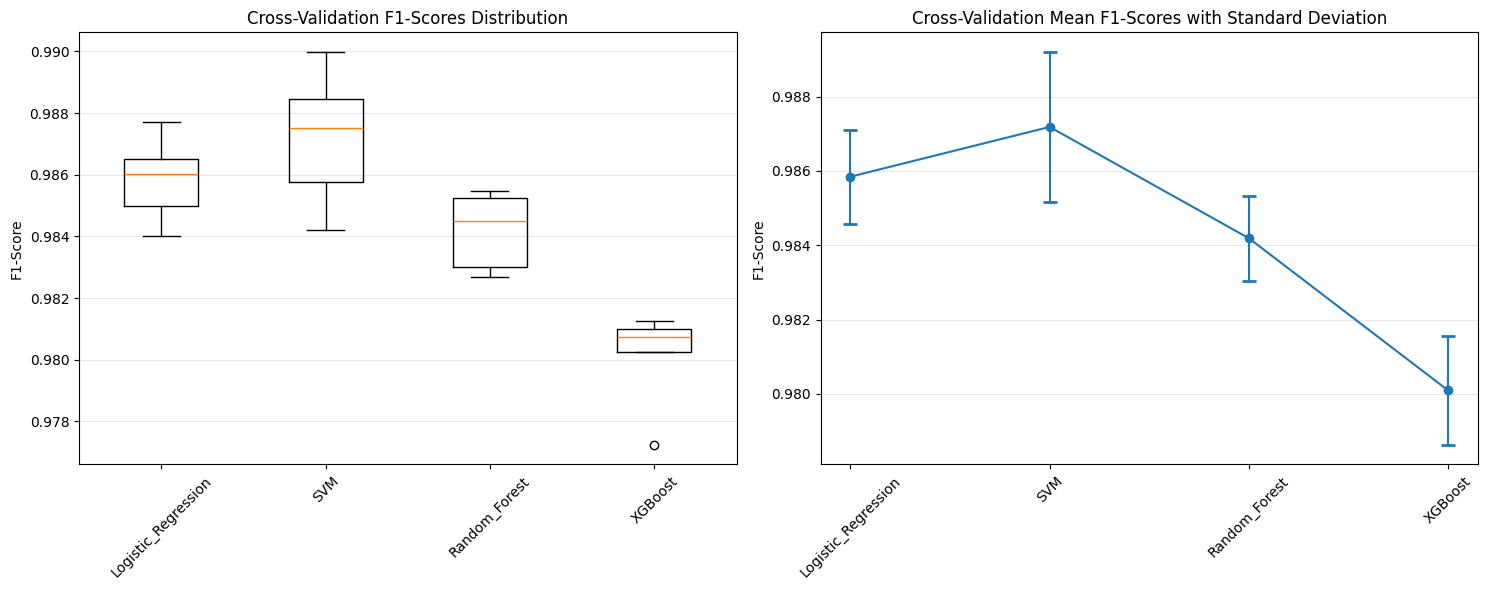

In [5]:
print("\n1. CROSS-VALIDATION ANALYSIS")
print("=" * 60)

# Define models to evaluate
models_to_evaluate = {
    'Logistic_Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
        'vectorizer': TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=2, max_df=0.95, stop_words='english')
    },
    'SVM': {
        'model': SVC(kernel='rbf', random_state=42, class_weight='balanced', probability=True),
        'vectorizer': TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=2, max_df=0.95, stop_words='english')
    },
    'Random_Forest': {
        'model': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1),
        'vectorizer': TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=2, max_df=0.95, stop_words='english')
    }
}

# Add gradient boosting models if available
if XGB_AVAILABLE:
    models_to_evaluate['XGBoost'] = {
        'model': xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, eval_metric='mlogloss'),
        'vectorizer': TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=2, max_df=0.95, stop_words='english')
    }

# Stratified K-Fold Cross-Validation
cv_folds = 5
skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

cv_results = {}

for model_name, model_config in models_to_evaluate.items():
    print(f"\n📊 Cross-validating {model_name}...")
    
    model = model_config['model']
    vectorizer = model_config['vectorizer']
    
    # Transform text to features
    X_transformed = vectorizer.fit_transform(X_full)
    
    # Perform cross-validation
    cv_scores = cross_val_score(
        model, X_transformed, y_full, 
        cv=skf, scoring='f1_weighted', n_jobs=-1
    )
    
    cv_results[model_name] = {
        'scores': cv_scores,
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'min': cv_scores.min(),
        'max': cv_scores.max()
    }
    
    print(f"   F1-Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"   Range: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")

# Create CV results DataFrame
cv_df = pd.DataFrame({
    name: [results['mean'], results['std']]
    for name, results in cv_results.items()
}, index=['Mean F1-Score', 'Std F1-Score']).T

print(f"\nCROSS-VALIDATION SUMMARY:")
print("=" * 50)
print(cv_df.round(4))

# Visualize CV results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Box plot of CV scores
cv_scores_list = [results['scores'] for results in cv_results.values()]
ax1.boxplot(cv_scores_list, labels=list(cv_results.keys()))
ax1.set_title('Cross-Validation F1-Scores Distribution')
ax1.set_ylabel('F1-Score')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Mean scores with error bars
means = [results['mean'] for results in cv_results.values()]
stds = [results['std'] for results in cv_results.values()]
models = list(cv_results.keys())

ax2.errorbar(range(len(models)), means, yerr=stds, fmt='o-', capsize=5, capthick=2)
ax2.set_xticks(range(len(models)))
ax2.set_xticklabels(models, rotation=45)
ax2.set_title('Cross-Validation Mean F1-Scores with Standard Deviation')
ax2.set_ylabel('F1-Score')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/cross_validation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. Detailed Confusion Matrix Analysis


2. DETAILED CONFUSION MATRIX ANALYSIS
Best CV model: SVM

PER-CLASS PERFORMANCE (Top 10 and Bottom 10):
TOP 10 PERFORMING CLASSES:
                       Class  Precision  Recall  F1-Score
13            Group Bookings      1.000   1.000     1.000
2            Business Travel      1.000   1.000     1.000
8         Duty-Free Shopping      1.000   1.000     1.000
26          Travel Insurance      1.000   1.000     1.000
6    Complaints and Feedback      1.000   0.994     0.997
25      Travel Documentation      0.994   1.000     0.997
28           Travel Vouchers      0.993   1.000     0.997
21  Promotions and Discounts      1.000   0.993     0.996
14        In-flight Services      0.992   1.000     0.996
5    Child and Infant Travel      1.000   0.991     0.996

BOTTOM 10 PERFORMING CLASSES:
                   Class  Precision  Recall  F1-Score
0       Airport Services      0.990   0.980     0.985
10        Flight Changes      0.987   0.981     0.984
15        Lost and Found      0.977  

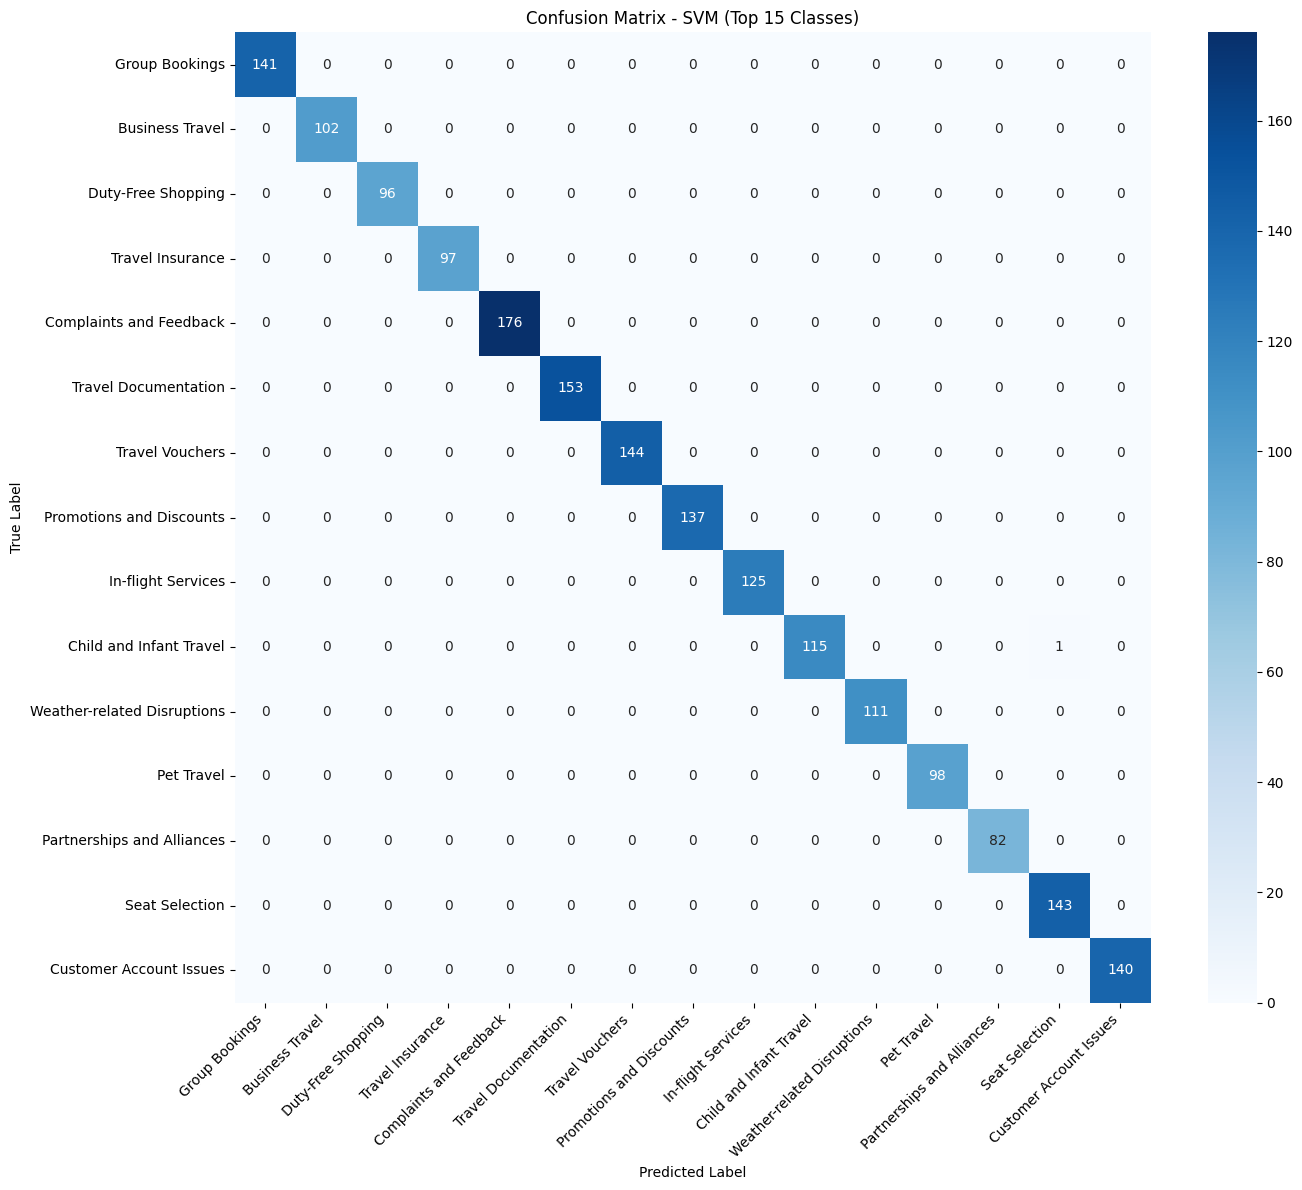

In [6]:
print("\n2. DETAILED CONFUSION MATRIX ANALYSIS")
print("=" * 60)

# Select best model from CV for detailed analysis
best_cv_model = max(cv_results.keys(), key=lambda x: cv_results[x]['mean'])
print(f"Best CV model: {best_cv_model}")

# Train best model on full dataset for detailed analysis
best_model_config = models_to_evaluate[best_cv_model]
best_model = best_model_config['model']
best_vectorizer = best_model_config['vectorizer']

# Split data for final evaluation
split_idx = len(train_split)
X_train_eval = X_full[:split_idx]
y_train_eval = y_full[:split_idx]
X_val_eval = X_full[split_idx:]
y_val_eval = y_full[split_idx:]

# Train and predict
X_train_vec = best_vectorizer.fit_transform(X_train_eval)
X_val_vec = best_vectorizer.transform(X_val_eval)
best_model.fit(X_train_vec, y_train_eval)
y_pred = best_model.predict(X_val_vec)

# Generate detailed confusion matrix
cm = confusion_matrix(y_val_eval, y_pred)
class_names = label_encoder.classes_

# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_val_eval, y_pred, average=None)

# Create per-class performance DataFrame
per_class_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
}).sort_values('F1-Score', ascending=False)

print(f"\nPER-CLASS PERFORMANCE (Top 10 and Bottom 10):")
print("=" * 70)
print("TOP 10 PERFORMING CLASSES:")
print(per_class_df.head(10)[['Class', 'Precision', 'Recall', 'F1-Score']].round(3))
print("\nBOTTOM 10 PERFORMING CLASSES:")
print(per_class_df.tail(10)[['Class', 'Precision', 'Recall', 'F1-Score']].round(3))

# Visualize confusion matrix (top 15 classes for readability)
top_classes_idx = per_class_df.head(15).index
cm_subset = cm[np.ix_(top_classes_idx, top_classes_idx)]
top_class_names = class_names[top_classes_idx]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_subset, 
           annot=True, fmt='d', cmap='Blues',
           xticklabels=top_class_names, 
           yticklabels=top_class_names)
plt.title(f'Confusion Matrix - {best_cv_model} (Top 15 Classes)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../reports/figures/detailed_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Error Analysis

In [7]:
print("\n3. ERROR ANALYSIS")
print("=" * 40)

# Find misclassified examples
misclassified_idx = y_val_eval != y_pred
misclassified_X = X_val_eval[misclassified_idx]
misclassified_y_true = y_val_eval[misclassified_idx]
misclassified_y_pred = y_pred[misclassified_idx]

print(f"Total misclassifications: {len(misclassified_X)} out of {len(y_val_eval)} ({len(misclassified_X)/len(y_val_eval)*100:.2f}%)")

# Analyze error patterns
error_patterns = {}
for true_label, pred_label in zip(misclassified_y_true, misclassified_y_pred):
    true_class = class_names[true_label]
    pred_class = class_names[pred_label]
    pattern = f"{true_class} → {pred_class}"
    error_patterns[pattern] = error_patterns.get(pattern, 0) + 1

# Top error patterns
top_errors = sorted(error_patterns.items(), key=lambda x: x[1], reverse=True)[:10]

print(f"\nTOP 10 ERROR PATTERNS:")
print("=" * 50)
for pattern, count in top_errors:
    print(f"{pattern}: {count} errors")

# Show example misclassifications
print(f"\nEXAMPLE MISCLASSIFICATIONS:")
print("=" * 50)
for i, (pattern, count) in enumerate(top_errors[:5]):
    true_class, pred_class = pattern.split(' → ')
    
    # Find examples of this error pattern
    pattern_examples = []
    for j, (x, y_true, y_pred_single) in enumerate(zip(misclassified_X, misclassified_y_true, misclassified_y_pred)):
        if class_names[y_true] == true_class and class_names[y_pred_single] == pred_class:
            pattern_examples.append(x)
            if len(pattern_examples) >= 2:  # Show 2 examples
                break
    
    print(f"\n{i+1}. {pattern} ({count} errors):")
    for k, example in enumerate(pattern_examples):
        print(f"   Example {k+1}: \"{example}\"")


3. ERROR ANALYSIS
Total misclassifications: 51 out of 4000 (1.27%)

TOP 10 ERROR PATTERNS:
Frequent Flyer Miles → Loyalty Programs: 5 errors
Baggage Policies → Lost and Found: 4 errors
Flight Bookings → Payment Issues: 3 errors
COVID-19 Policies → Travel Restrictions: 3 errors
Lost and Found → Baggage Policies: 3 errors
Travel Restrictions → COVID-19 Policies: 2 errors
Flight Changes → Flight Status: 2 errors
Check-in Procedures → Flight Status: 2 errors
Special Assistance → In-flight Services: 1 errors
Flight Changes → Refunds and Compensation: 1 errors

EXAMPLE MISCLASSIFICATIONS:

1. Frequent Flyer Miles → Loyalty Programs (5 errors):
   Example 1: "sign frequent flyer program"
   Example 2: "perk frequent flyer"

2. Baggage Policies → Lost and Found (4 errors):
   Example 1: "luggage damage lose"
   Example 2: "baggage lose delayed"

3. Flight Bookings → Payment Issues (3 errors):
   Example 1: "book payment option"
   Example 2: "need book payment option available"

4. COVID-19 P

## 4. Learning Curves Analysis


4. LEARNING CURVES ANALYSIS


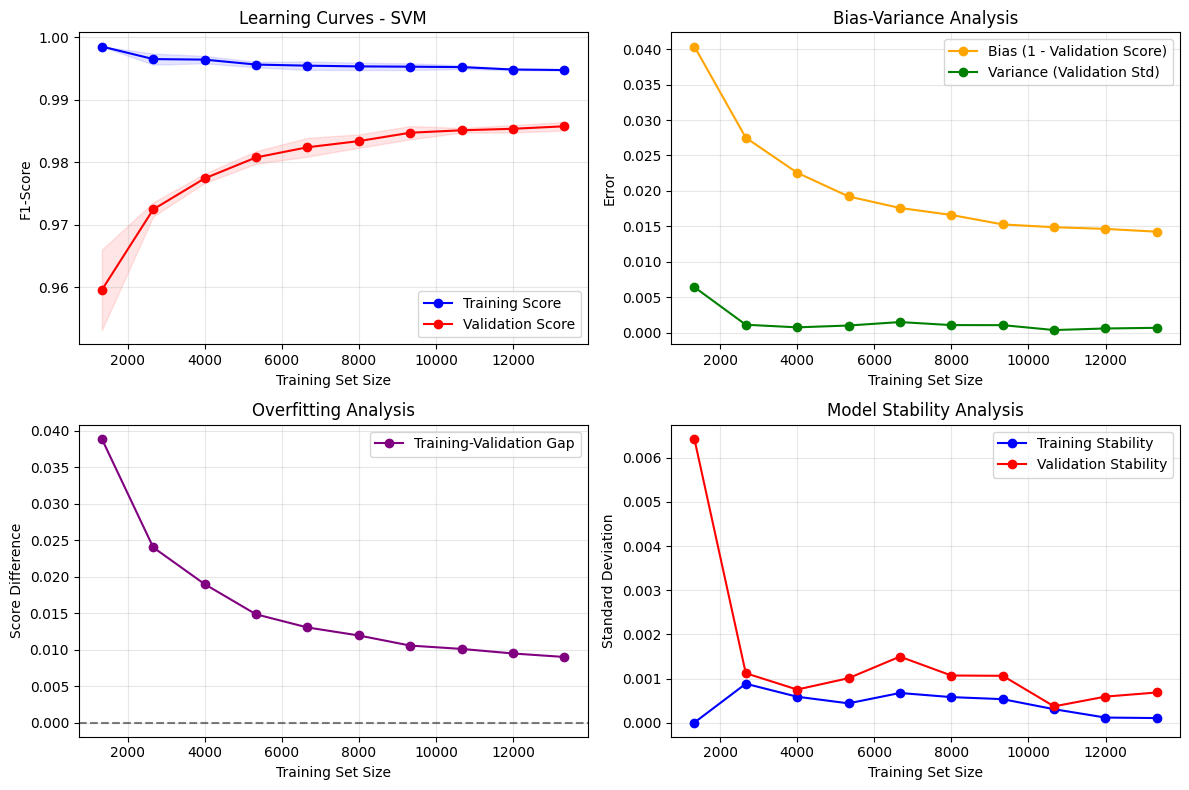


LEARNING CURVE INSIGHTS:
Final validation F1-score: 0.9858
Training-validation gap: 0.0090
Model stability (val std): 0.0007
Well-balanced model (small train-val gap)
High stability (low validation variance)


In [8]:
print("\n4. LEARNING CURVES ANALYSIS")
print("=" * 50)

# Generate learning curves for best model
train_sizes = np.linspace(0.1, 1.0, 10)
X_learning = best_vectorizer.fit_transform(X_full)

train_sizes_abs, train_scores, val_scores = learning_curve(
    best_model, X_learning, y_full,
    train_sizes=train_sizes,
    cv=3,  # Reduced CV for speed
    scoring='f1_weighted',
    n_jobs=-1,
    random_state=42
)

# Calculate means and stds
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(train_sizes_abs, train_mean, 'o-', color='blue', label='Training Score')
plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes_abs, val_mean, 'o-', color='red', label='Validation Score')
plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
plt.xlabel('Training Set Size')
plt.ylabel('F1-Score')
plt.title(f'Learning Curves - {best_cv_model}')
plt.legend()
plt.grid(alpha=0.3)

# Bias-Variance Analysis
plt.subplot(2, 2, 2)
bias = 1 - val_mean
variance = val_std
plt.plot(train_sizes_abs, bias, 'o-', label='Bias (1 - Validation Score)', color='orange')
plt.plot(train_sizes_abs, variance, 'o-', label='Variance (Validation Std)', color='green')
plt.xlabel('Training Set Size')
plt.ylabel('Error')
plt.title('Bias-Variance Analysis')
plt.legend()
plt.grid(alpha=0.3)

# Training vs Validation Gap
plt.subplot(2, 2, 3)
gap = train_mean - val_mean
plt.plot(train_sizes_abs, gap, 'o-', color='purple', label='Training-Validation Gap')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Training Set Size')
plt.ylabel('Score Difference')
plt.title('Overfitting Analysis')
plt.legend()
plt.grid(alpha=0.3)

# Model Stability
plt.subplot(2, 2, 4)
plt.plot(train_sizes_abs, train_std, 'o-', color='blue', label='Training Stability')
plt.plot(train_sizes_abs, val_std, 'o-', color='red', label='Validation Stability')
plt.xlabel('Training Set Size')
plt.ylabel('Standard Deviation')
plt.title('Model Stability Analysis')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/learning_curves_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze learning curve results
final_gap = train_mean[-1] - val_mean[-1]
final_val_score = val_mean[-1]
final_stability = val_std[-1]

print(f"\nLEARNING CURVE INSIGHTS:")
print("=" * 40)
print(f"Final validation F1-score: {final_val_score:.4f}")
print(f"Training-validation gap: {final_gap:.4f}")
print(f"Model stability (val std): {final_stability:.4f}")

if final_gap > 0.05:
    print("Potential overfitting detected (large train-val gap)")
elif final_gap < 0.01:
    print("Well-balanced model (small train-val gap)")
else:
    print("Acceptable generalization (moderate train-val gap)")

if final_stability < 0.02:
    print("High stability (low validation variance)")
else:
    print("Consider more data or regularization (high variance)")

## 5. Hyperparameter Tuning

In [9]:
print("\n5. HYPERPARAMETER TUNING")
print("=" * 50)

# Define hyperparameter grids for top models
hyperparameter_grids = {
    'Logistic_Regression': {
        'C': [0.1, 1.0, 10.0, 100.0],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'SVM': {
        'C': [0.1, 1.0, 10.0],
        'gamma': ['scale', 'auto', 0.001, 0.01],
        'kernel': ['rbf', 'linear']
    },
    'Random_Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
}

# Add XGBoost if available
if XGB_AVAILABLE:
    hyperparameter_grids['XGBoost'] = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }

tuning_results = {}

# Tune top 2 models from CV results
top_models = sorted(cv_results.keys(), key=lambda x: cv_results[x]['mean'], reverse=True)[:2]

for model_name in top_models:
    if model_name not in hyperparameter_grids:
        continue
        
    print(f"\n Tuning {model_name}...")
    
    model_config = models_to_evaluate[model_name]
    base_model = model_config['model']
    vectorizer = model_config['vectorizer']
    param_grid = hyperparameter_grids[model_name]
    
    # Transform features
    X_transformed = vectorizer.fit_transform(X_full)
    
    # Randomized search for efficiency
    random_search = RandomizedSearchCV(
        base_model,
        param_distributions=param_grid,
        n_iter=20,  # Limited iterations for speed
        cv=3,       # Reduced CV for speed
        scoring='f1_weighted',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    
    random_search.fit(X_transformed, y_full)
    
    tuning_results[model_name] = {
        'best_params': random_search.best_params_,
        'best_score': random_search.best_score_,
        'improvement': random_search.best_score_ - cv_results[model_name]['mean']
    }
    
    print(f"   Best parameters: {random_search.best_params_}")
    print(f"   Best CV score: {random_search.best_score_:.4f}")
    print(f"   Improvement: {tuning_results[model_name]['improvement']:+.4f}")


5. HYPERPARAMETER TUNING

 Tuning SVM...
   Best parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0}
   Best CV score: 0.9858
   Improvement: -0.0014

 Tuning Logistic_Regression...
   Best parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10.0}
   Best CV score: 0.9871
   Improvement: +0.0013


## 6. Final Model Comparison


6. FINAL MODEL COMPARISON
FINAL MODEL RANKINGS:
                 Model  Base_F1  Base_Std  Tuned_F1  Improvement  Final_F1
0  Logistic_Regression   0.9858    0.0013    0.9871       0.0013    0.9871
1                  SVM   0.9872    0.0020    0.9858      -0.0014    0.9858
2        Random_Forest   0.9842    0.0011       NaN       0.0000    0.9842
3              XGBoost   0.9801    0.0015       NaN       0.0000    0.9801


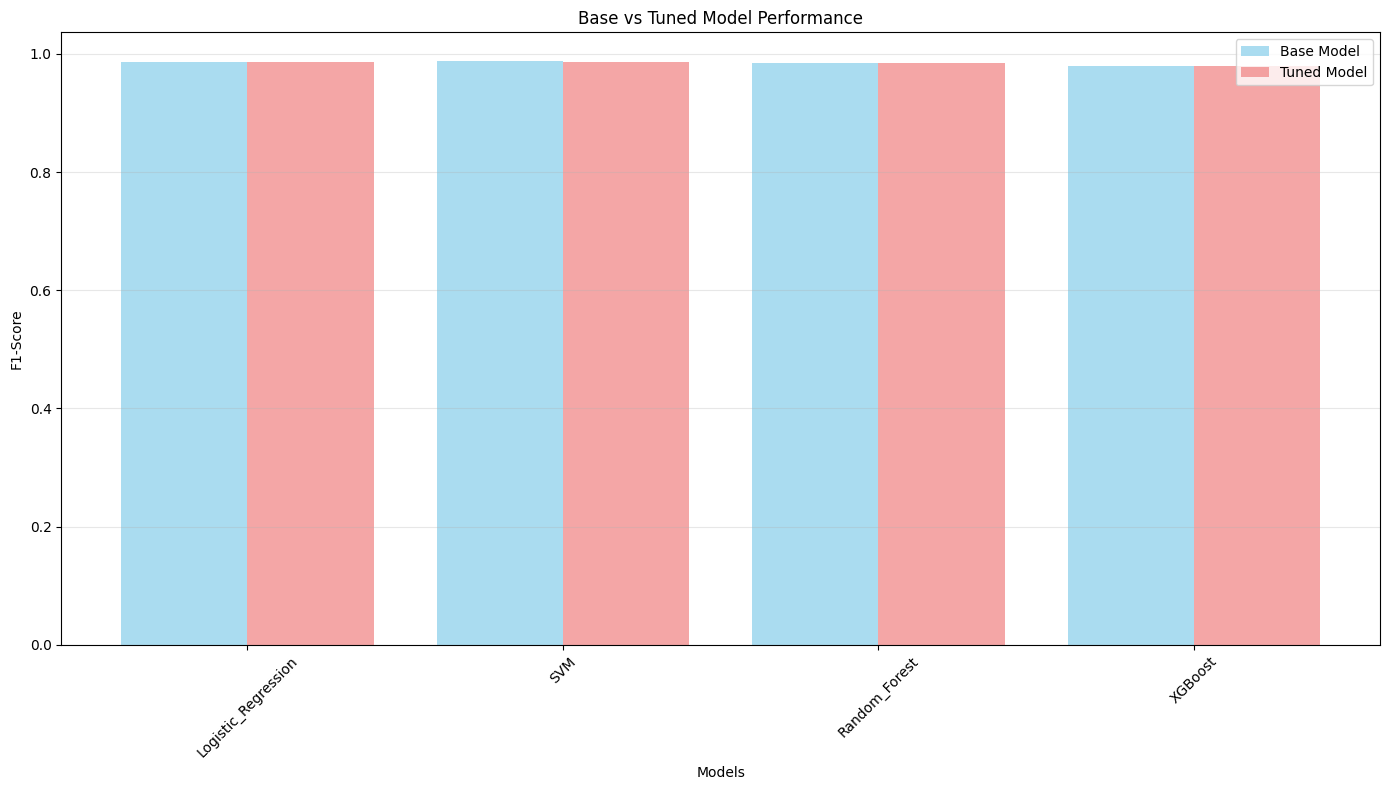

In [10]:
print("\n6. FINAL MODEL COMPARISON")
print("=" * 60)

# Create comprehensive results summary
final_results = []

for model_name in cv_results.keys():
    base_score = cv_results[model_name]['mean']
    base_std = cv_results[model_name]['std']
    
    if model_name in tuning_results:
        tuned_score = tuning_results[model_name]['best_score']
        improvement = tuning_results[model_name]['improvement']
        final_score = tuned_score
    else:
        tuned_score = None
        improvement = 0
        final_score = base_score
    
    final_results.append({
        'Model': model_name,
        'Base_F1': base_score,
        'Base_Std': base_std,
        'Tuned_F1': tuned_score,
        'Improvement': improvement,
        'Final_F1': final_score
    })

final_df = pd.DataFrame(final_results).sort_values('Final_F1', ascending=False)

print("FINAL MODEL RANKINGS:")
print("=" * 80)
print(final_df.round(4))

# Visualize final comparison
plt.figure(figsize=(14, 8))

x_pos = np.arange(len(final_df))
base_scores = final_df['Base_F1']
final_scores = final_df['Final_F1']

plt.bar(x_pos - 0.2, base_scores, 0.4, label='Base Model', alpha=0.7, color='skyblue')
plt.bar(x_pos + 0.2, final_scores, 0.4, label='Tuned Model', alpha=0.7, color='lightcoral')

plt.xlabel('Models')
plt.ylabel('F1-Score')
plt.title('Base vs Tuned Model Performance')
plt.xticks(x_pos, final_df['Model'], rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/final_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Save Optimized Models

In [11]:
print("\n7. SAVING OPTIMIZED MODELS")
print("=" * 50)

# Get best overall model
best_final_model = final_df.iloc[0]['Model']
print(f"Best final model: {best_final_model}")

# Train and save the best tuned model
if best_final_model in tuning_results:
    best_params = tuning_results[best_final_model]['best_params']
    
    # Create optimized model with best parameters
    base_model_config = models_to_evaluate[best_final_model]
    optimized_model = base_model_config['model'].set_params(**best_params)
    optimized_vectorizer = base_model_config['vectorizer']
    
    # Train on full dataset
    X_full_vec = optimized_vectorizer.fit_transform(X_full)
    optimized_model.fit(X_full_vec, y_full)
    
    # Save optimized model
    joblib.dump(optimized_model, f'../models/optimized_{best_final_model.lower()}_model.pkl')
    joblib.dump(optimized_vectorizer, f'../models/optimized_{best_final_model.lower()}_vectorizer.pkl')
    
    print(f"   Optimized {best_final_model} saved")
    print(f"   Parameters: {best_params}")
    print(f"   Performance: {final_df.iloc[0]['Final_F1']:.4f}")

# Save evaluation results
evaluation_summary = {
    'evaluation_date': datetime.now().isoformat(),
    'best_model': best_final_model,
    'best_f1_score': float(final_df.iloc[0]['Final_F1']),
    'cross_validation_results': {k: {
        'mean': float(v['mean']),
        'std': float(v['std'])
    } for k, v in cv_results.items()},
    'hyperparameter_tuning': {k: {
        'best_params': v['best_params'],
        'best_score': float(v['best_score']),
        'improvement': float(v['improvement'])
    } for k, v in tuning_results.items()},
    'error_analysis': {
        'total_errors': len(misclassified_X),
        'error_rate': len(misclassified_X) / len(y_val_eval),
        'top_error_patterns': dict(top_errors[:5])
    }
}

with open('../models/evaluation_summary.json', 'w') as f:
    json.dump(evaluation_summary, f, indent=2)

print(f"\n Evaluation summary saved to '../models/evaluation_summary.json'")


7. SAVING OPTIMIZED MODELS
Best final model: Logistic_Regression
   Optimized Logistic_Regression saved
   Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10.0}
   Performance: 0.9871

 Evaluation summary saved to '../models/evaluation_summary.json'


## 8. Production Recommendations

In [12]:
print("\n8. PRODUCTION RECOMMENDATIONS")
print("=" * 60)

best_score = final_df.iloc[0]['Final_F1']
error_rate = len(misclassified_X) / len(y_val_eval)

print(f"📊 PERFORMANCE SUMMARY:")
print(f"   Best Model: {best_final_model}")
print(f"   F1-Score: {best_score:.4f} ({best_score*100:.2f}%)")
print(f"   Error Rate: {error_rate:.4f} ({error_rate*100:.2f}%)")
print(f"   Stability: {cv_results[best_final_model]['std']:.4f}")

print(f"\n🚀 PRODUCTION RECOMMENDATIONS:")
print("=" * 40)

if best_score >= 0.98:
    print(" EXCELLENT: Ready for production deployment")
    confidence_threshold = 0.95
elif best_score >= 0.95:
    print(" GOOD: Suitable for production with monitoring")
    confidence_threshold = 0.90
else:
    print(" FAIR: Consider additional optimization before production")
    confidence_threshold = 0.85

print(f"\n DEPLOYMENT STRATEGY:")
print(f"   • Confidence threshold: {confidence_threshold}")
print(f"   • Auto-route predictions above {confidence_threshold}")
print(f"   • Human review for predictions below {confidence_threshold}")
print(f"   • Monitor {len(top_errors)} most common error patterns")
print(f"   • Retrain monthly with new data")

print(f"\n MONITORING ALERTS:")
print(f"   • Accuracy drops below {best_score - 0.02:.3f}")
print(f"   • New categories emerge (confidence < 0.5)")
print(f"   • Data drift in text patterns")

print(f"\n MODEL EVALUATION COMPLETE!")
print("Ready for production deployment! 🚀")


8. PRODUCTION RECOMMENDATIONS
📊 PERFORMANCE SUMMARY:
   Best Model: Logistic_Regression
   F1-Score: 0.9871 (98.71%)
   Error Rate: 0.0127 (1.27%)
   Stability: 0.0013

🚀 PRODUCTION RECOMMENDATIONS:
 EXCELLENT: Ready for production deployment

 DEPLOYMENT STRATEGY:
   • Confidence threshold: 0.95
   • Auto-route predictions above 0.95
   • Human review for predictions below 0.95
   • Monitor 10 most common error patterns
   • Retrain monthly with new data

 MONITORING ALERTS:
   • Accuracy drops below 0.967
   • New categories emerge (confidence < 0.5)
   • Data drift in text patterns

 MODEL EVALUATION COMPLETE!
Ready for production deployment! 🚀
